In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
from qiskit.transpiler import generate_preset_pass_manager

qasm_dir = "/Users/debarthipal/Library/CloudStorage/OneDrive-IBM/Desktop/VS files/QASM_circuits_medium"
qasm_files = sorted([
    f for f in os.listdir(qasm_dir)
    if f.endswith(".qasm")
])
print(qasm_files)

['bigadder_n18.qasm', 'bv_n14.qasm', 'bv_n19.qasm', 'bwt_n21.qasm', 'cat_state_n22.qasm', 'cc_n12.qasm', 'dnn_n16.qasm', 'gcm_h6.qasm', 'ghz_state_n23.qasm', 'ising_n26.qasm', 'knn_n25.qasm', 'multiplier_n15.qasm', 'multiply_n13.qasm', 'qec9xz_n17.qasm', 'qf21_n15.qasm', 'qft_n18.qasm', 'sat_n11.qasm', 'seca_n11.qasm', 'square_root_n18.qasm', 'swap_test_n25.qasm', 'vqe_n24.qasm', 'wstate_n27.qasm']


In [4]:
from howtoslice import do_backpropagation
from qiskit_ibm_runtime.fake_provider import FakeTorino
backend = FakeTorino()

from qiskit_addon_obp.utils.simplify import OperatorBudget

op_budget = OperatorBudget(max_qwc_groups=8)

In [5]:
from qiskit.transpiler.passes import RemoveBarriers
import json
circ_dic={}
for index, file in enumerate(qasm_files, start=1):
    n=QuantumCircuit.from_qasm_file(file).num_qubits
    observable_terms = [
            "I"*(i-1) + "Z" + "I"*(n - i)
            for i in range(1, n+1)
        ]
    observable = SparsePauliOp(observable_terms, coeffs=[1/(n)] * (n))
    circuit=QuantumCircuit.from_qasm_file(file)
    pm=generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=1)
    circuit=RemoveBarriers()(circuit)
    trans_circuit=pm.run(circuit)
    isa_observable=observable.apply_layout(trans_circuit.layout)
    num_slices, depth_val = do_backpropagation(trans_circuit, isa_observable, op_budget, backend)
    
    circ_dic[index] = {"filename":file, 
                      "Depth after slicing by depth, gate, color respectively are: ": depth_val,
                      "Slice by depth, gate and color seperate the circuit in: ": num_slices 
                    }
    
    json_obj=json.dumps(circ_dic, indent=4)
    with open("slicing_depth_medium_FakeTorino_Z.json", "w") as f:
        f.write(json_obj)   #Saving to a JSON file

Reached the specified max_seconds timeout!
Reached the specified max_seconds timeout!
Reached the specified max_seconds timeout!
Reached the specified max_seconds timeout!
Reached the specified max_seconds timeout!
Reached the specified max_seconds timeout!
Reached the specified max_seconds timeout!
Reached the specified max_seconds timeout!
Reached the specified max_seconds timeout!


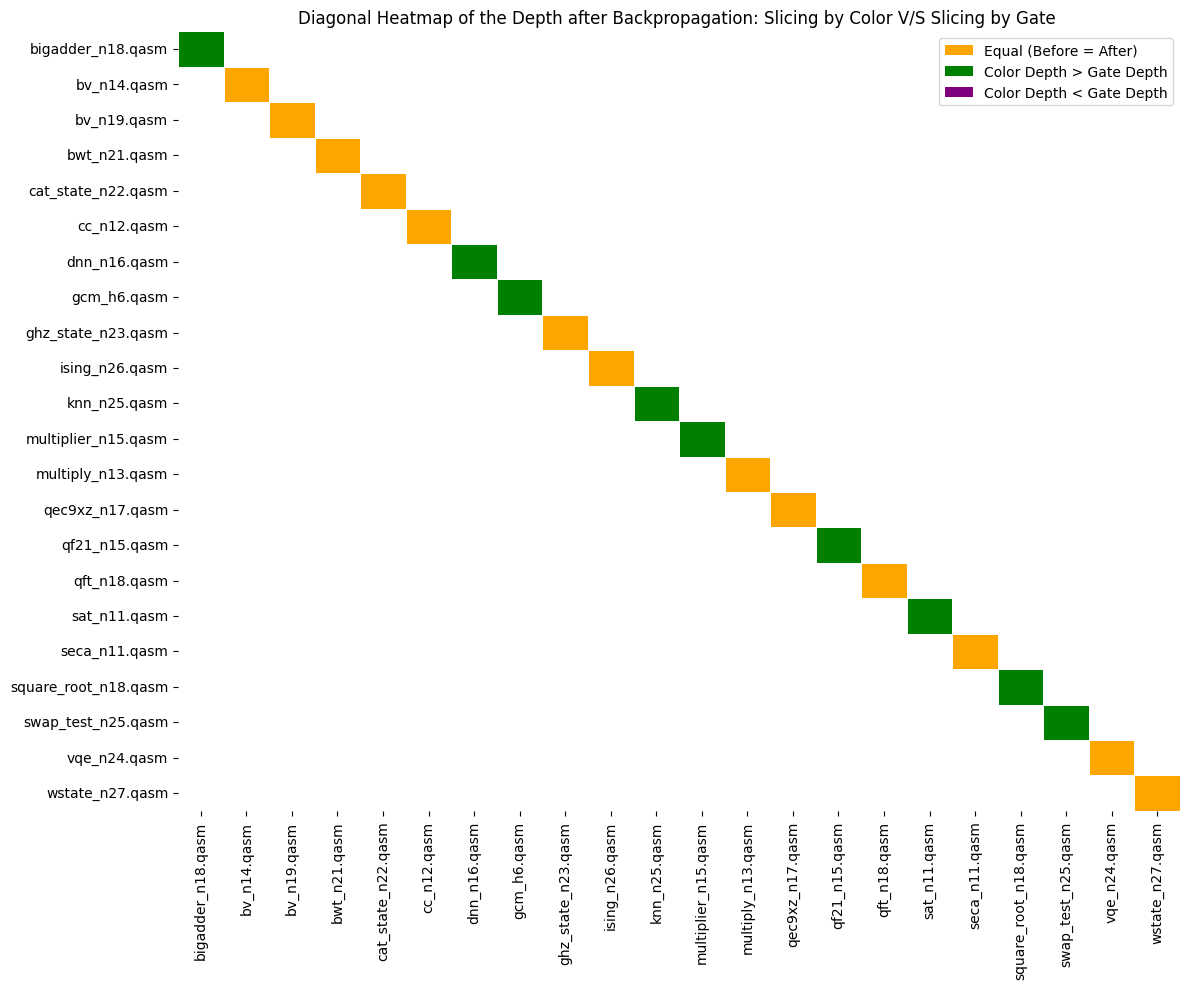

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Custom color map: 0=orange, 1=green, 2=purple, 3=white
colors = ListedColormap(['orange', 'green', 'purple', 'white'])

# Convert dictionary to DataFrame and fill Nones with 0
df = pd.DataFrame(circ_dic).T.fillna(0)

# Extract values
color = df["Depth after slicing by depth, gate, color respectively are: "].apply(lambda x: x[2]).to_numpy(dtype=float)
color=np.nan_to_num(color, nan=0)
gate= df["Depth after slicing by depth, gate, color respectively are: "].apply(lambda x: x[1]).to_numpy(dtype=float)
gate=np.nan_to_num(gate, nan=0)
labels = df["filename"].tolist()

# Init matrix with 3 (default color: white)
matrix = np.full((len(labels), len(labels)), 3)

# Apply logic only to diagonal where filenames match
for i in range(len(labels)):
        if gate[i] == color[i]:
            matrix[i, i] = 0  # orange
        elif color[i] > gate[i]:
            matrix[i, i] = 1  # green
        elif color[i] < gate[i]:
            matrix[i,i] = 2   # purple
        else:
            matrix[i,i] = 3
# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(matrix, cmap=colors, cbar=False,linewidths=0.5,xticklabels=labels, yticklabels=labels)
plt.title("Diagonal Heatmap of the Depth after Backpropagation: Slicing by Color V/S Slicing by Gate ")

# Legend
legend_elements = [
    Patch(facecolor='orange', label='Equal (Before = After)'),
    Patch(facecolor='green', label='Color Depth > Gate Depth'),
    Patch(facecolor='purple', label='Color Depth < Gate Depth')
]
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.savefig("slice_for_medium_circuits_color_vs_gate.png")
plt.show()